 ### 02: Attention Pattern Analysis

In [21]:
# Importing necessary libraries
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict
import pandas as pd
import yaml
# Setting random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
import warnings
warnings.filterwarnings("ignore")

In [22]:
# Loading configuration from YAML file
with open("../config.yaml", "r") as f:
    model_config = yaml.safe_load(f)

In [23]:
# Loading the same model
model = model_config['model']['name']
device = "cuda" if torch.cuda.is_available() else "cpu"

In [24]:
tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelForCausalLM.from_pretrained(
    model,
    output_attentions=True,
    output_hidden_states=True,
).to(device)
config = model.config
model.eval()

Loading weights: 100%|██████████| 160/160 [00:00<00:00, 214.81it/s, Materializing param=transformer.wte.weight]                         
GPTNeoForCausalLM LOAD REPORT from: EleutherAI/gpt-neo-125M
Key                                                   | Status     |  | 
------------------------------------------------------+------------+--+-
transformer.h.{0...11}.attn.attention.masked_bias     | UNEXPECTED |  | 
transformer.h.{0, 2, 4, 6, 8, 10}.attn.attention.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_fe

1. Generating text while tracking attention

In [25]:
# Prompt to analyze attention patterns
prompt=model_config['analysis']['prompt']
inputs = tokenizer(prompt, return_tensors="pt").to(device)
input_length = inputs['input_ids'].shape[1]
print(f"Prompt: '{prompt}'")
print(f"Input tokens: {tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])}")
print(f"Number of input tokens: {input_length}")

Prompt: 'Marie Curie was a physicist who discovered radium. She was born in'
Input tokens: ['Marie', 'ĠCur', 'ie', 'Ġwas', 'Ġa', 'Ġphysicist', 'Ġwho', 'Ġdiscovered', 'Ġrad', 'ium', '.', 'ĠShe', 'Ġwas', 'Ġborn', 'Ġin']
Number of input tokens: 15


In [26]:
# Generating with attention tracking
with torch.no_grad():
    output = model.generate(
    **inputs,
    max_new_tokens=model_config['inference']['max_new_tokens'],
    do_sample=model_config['inference']['do_sample'],
    repetition_penalty=model_config['inference']['repetition_penalty'],
    return_dict_in_generate=True,
    output_attentions=True,
    output_hidden_states=True,
)
generated_text = tokenizer.decode(output.sequences[0], skip_special_tokens=True)
all_tokens = tokenizer.convert_ids_to_tokens(output.sequences[0])
print(f"\nGenerated text:\n{generated_text}")
print(f"\nAll tokens: {all_tokens}")
print(f"Total tokens: {len(all_tokens)}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Generated text:
Marie Curie was a physicist who discovered radium. She was born in the United States and moved to Canada when she was eight years old, where she studied physics at the University of Toronto. She became interested in nuclear fusion theory after her father died.

Curie

All tokens: ['Marie', 'ĠCur', 'ie', 'Ġwas', 'Ġa', 'Ġphysicist', 'Ġwho', 'Ġdiscovered', 'Ġrad', 'ium', '.', 'ĠShe', 'Ġwas', 'Ġborn', 'Ġin', 'Ġthe', 'ĠUnited', 'ĠStates', 'Ġand', 'Ġmoved', 'Ġto', 'ĠCanada', 'Ġwhen', 'Ġshe', 'Ġwas', 'Ġeight', 'Ġyears', 'Ġold', ',', 'Ġwhere', 'Ġshe', 'Ġstudied', 'Ġphysics', 'Ġat', 'Ġthe', 'ĠUniversity', 'Ġof', 'ĠToronto', '.', 'ĠShe', 'Ġbecame', 'Ġinterested', 'Ġin', 'Ġnuclear', 'Ġfusion', 'Ġtheory', 'Ġafter', 'Ġher', 'Ġfather', 'Ġdied', '.', 'Ċ', 'Ċ', 'Cur', 'ie']
Total tokens: 55


- The repetition penalty (10.0) prevents the model from getting stuck in loops, producing diverse text.
- The content is factually incorrect; Marie Curie was Polish and studied in Paris, not Canadian and educated at the University of Toronto, showing that while the model generates fluent text, it does not reliably produce accurate information.

2. Visualizing attention patterns

In [27]:
def plot_attention_heatmap(
    attention_weights: torch.Tensor,
    tokens: List[str],
    layer: int,
    head: int,
    title: str = None) -> None:
    """
    Plotting attention heatmap for a specific layer and head.
    Args:
        attention_weights: Attention tensor of shape (batch, heads, seq_len, seq_len)
        tokens: List of token strings
        layer: Layer index
        head: Head index
        title: Custom title for the plot
    Returns:
        None
    """
    # Extracting attention for specific head
    attn = attention_weights[0, head].cpu().numpy()
    # Plotting attention
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        attn,
        xticklabels=tokens,
        yticklabels=tokens,
        cmap='viridis',
        cbar_kws={'label': 'Attention Weight'},
        vmin=0,
        vmax=1
    )
    plot_title = title or f"Layer {layer}, Head {head}"
    plt.title(plot_title, fontsize=14, pad=20)
    plt.xlabel('Key Tokens', fontsize=12)
    plt.ylabel('Query Tokens', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [28]:
# Extracting attention from first generation step for analysis
first_step_attentions = output.attentions[0]

3. Identifying attention head types

In [29]:
def classify_attention_head(
    attention_weights: torch.Tensor,
    threshold: float = 0.5) -> Dict[str, float]:
    """
    Classifying attention head based on its patterns
    Args:
        attention_weights: Attention tensor of shape (seq_len, seq_len)
        threshold: Threshold for determining strong attention.
    Returns:
        Dictionary with scores for different head types
    """
    attn = attention_weights.cpu().numpy()
    seq_len = attn.shape[0]
    # Tracking previous token score: average attention to position i-1 from position i
    prev_token_score = 0
    if seq_len > 1:
        prev_diag = np.array([attn[i, i-1] for i in range(1, seq_len)])
        prev_token_score = np.mean(prev_diag)
    # First token score: average attention to first token
    first_token_score = np.mean(attn[:, 0])
    eps = 1e-10
    entropy = -np.sum(attn * np.log(attn + eps), axis=1)
    avg_entropy = np.mean(entropy)
    max_entropy = np.log(seq_len)
    normalized_entropy = avg_entropy / max_entropy if max_entropy > 0 else 0
    attention_dict={
        'prev_token_score': prev_token_score,
        'first_token_score': first_token_score,
        'entropy': avg_entropy,
        'normalized_entropy': normalized_entropy,
        'is_focused': normalized_entropy < 0.3,
        'is_broad': normalized_entropy > 0.7,
    }
    return attention_dict

In [30]:
head_classifications = []
for layer_idx in range(config.num_layers):
    layer_attns = first_step_attentions[layer_idx][0]
    for head_idx in range(config.num_heads):
        head_attn = layer_attns[head_idx]
        classification = classify_attention_head(head_attn)
        classification['layer'] = layer_idx
        classification['head'] = head_idx
        head_classifications.append(classification)

In [31]:
df_heads=pd.DataFrame(head_classifications)

In [32]:
#Previous token heads:How much each position attends to the token immediately before it (diagonal pattern)
prev_token_heads = df_heads.nlargest(5, 'prev_token_score')[['layer', 'head', 'prev_token_score']]
print("Previous token heads")
prev_token_heads

Previous token heads


,layer,head,prev_token_score
68,5,8,0.999932
57,4,9,0.954936
60,5,0,0.850843
85,7,1,0.580452
47,3,11,0.518428


This table identifies attention heads that specialise in looking at previous tokens.
- Layer 5 Head 8 is almost perfect with 99.99% attention to the previous token.
- Layer 5 Head 0 also shows strong specialisation at 85%, confirming Layer 5 as the primary sequential processing layer.
- Layer 7 Head 1 shows moderate focus (58%) and Layer 3 Head 11 (52%), indicating sequential dependency tracking spans early-to-middle layers before the network shifts to global aggregation.

In [41]:
#First token heads:How much all positions attend to the first token (vertical column pattern)
first_token_heads = df_heads.nlargest(5, 'first_token_score')[['layer', 'head', 'first_token_score']]
print("First token heads")
first_token_heads

First token heads


,layer,head,first_token_score
104,8,8,0.986407
73,6,1,0.982251
96,8,0,0.980189
72,6,0,0.974273
97,8,1,0.970624


- Layers 8 and 6 dominate first-token attention, with 3 heads from Layer 8 (Heads 8, 0, 1 at ~97-98%) and 2 heads from Layer 6 (Heads 1, 0 at ~97-98%).
- This suggests that from Layer 6 onward the model uses the first token ("Marie") as a summary anchor to aggregate global sentence-level information, contrasting with the sequential dependency tracking seen in Layer 5.

In [34]:
#Most focused token heads:Attention spread (0 = focused, 1 = uniform across all tokens)
focused_heads = df_heads.nsmallest(5, 'normalized_entropy')[['layer', 'head', 'normalized_entropy']]
print("Most focused token heads")
focused_heads

Most focused token heads


,layer,head,normalized_entropy
68,5,8,0.000222
136,11,4,0.002704
76,6,4,0.011462
2,0,2,0.016537
73,6,1,0.027413


- Layer 5 Head 8 (entropy 0.0002) is the most focused head in the network,the same head that topped the previous-token table, confirming it as a pure sequential dependency tracker.
- Layer 11 Head 4 (0.0027) and Layer 6 Heads 4 and 1 also appear, showing focused heads span both middle and late layers, not just early ones.

In [ ]:
#Most broad token heads
broad_heads = df_heads.nlargest(5, 'normalized_entropy')[['layer', 'head', 'normalized_entropy']]
print("Most broad token heads")
broad_heads

Most broad token heads


,layer,head,normalized_entropy
18,1,6,0.649081
12,1,0,0.602803
22,1,10,0.594810
21,1,9,0.574932
17,1,5,0.568927


- Layer 1 dominates all 5 broadest heads (entropy ~0.57-0.65), spreading 
  attention widely across all tokens.
- This confirms early layers gather diverse contextual information broadly, 
  middle layers specialise and focus sharply (Layer 5), and later layers 
  (Layer 6-8) use focused first-token attention for global aggregation
  revealing a clear computational pipeline through the network.

Visualizing Previous Token Head:


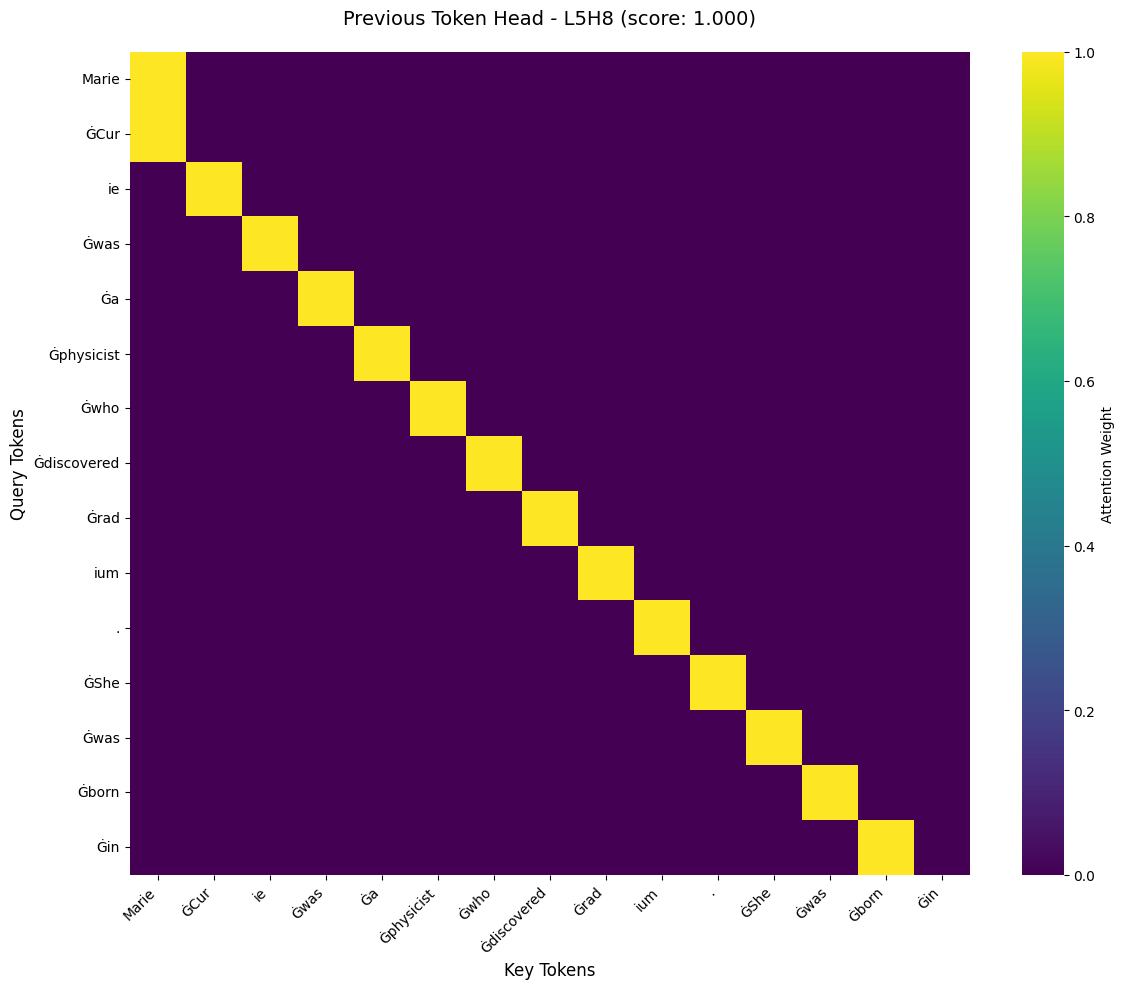


Visualizing First Token Head:


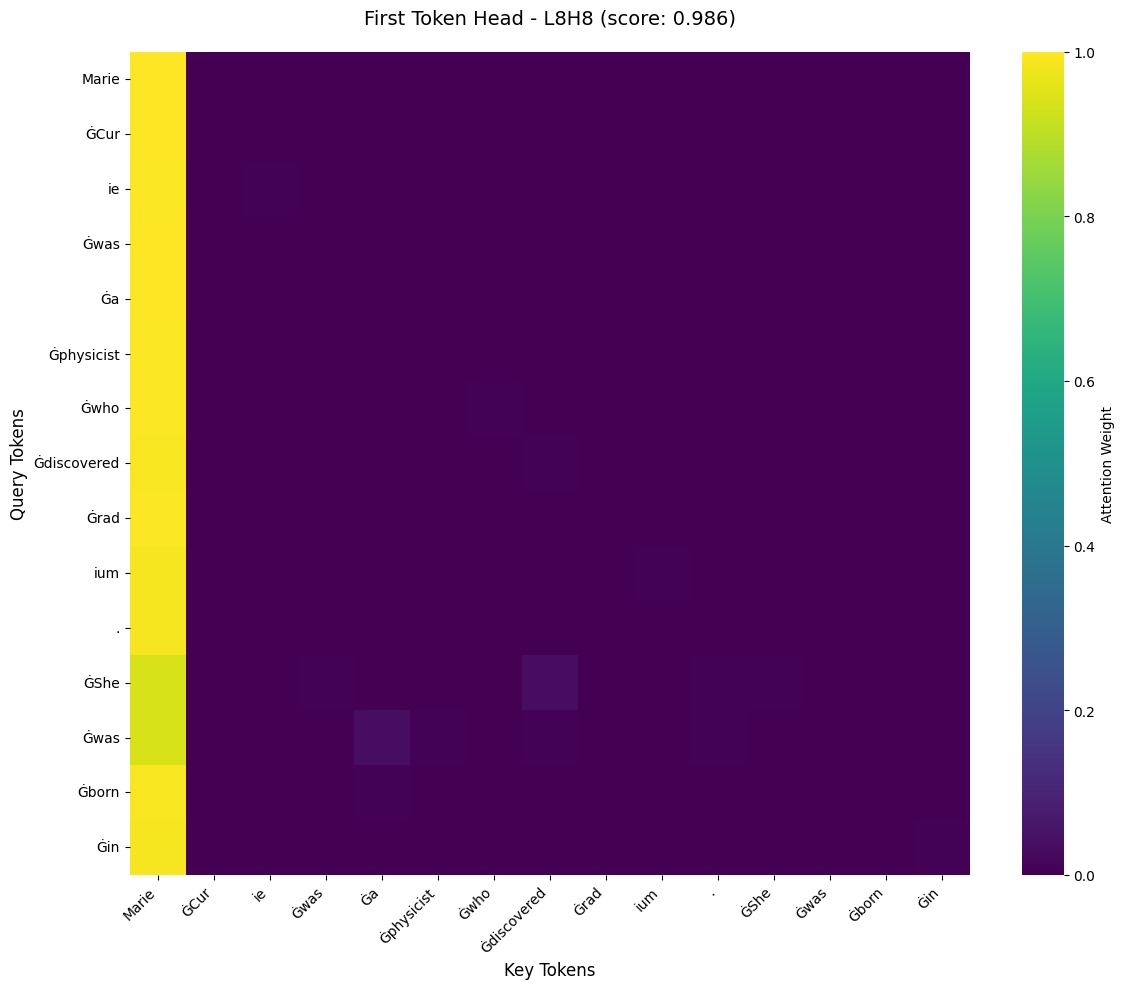


Visualizing Most Focused Head:


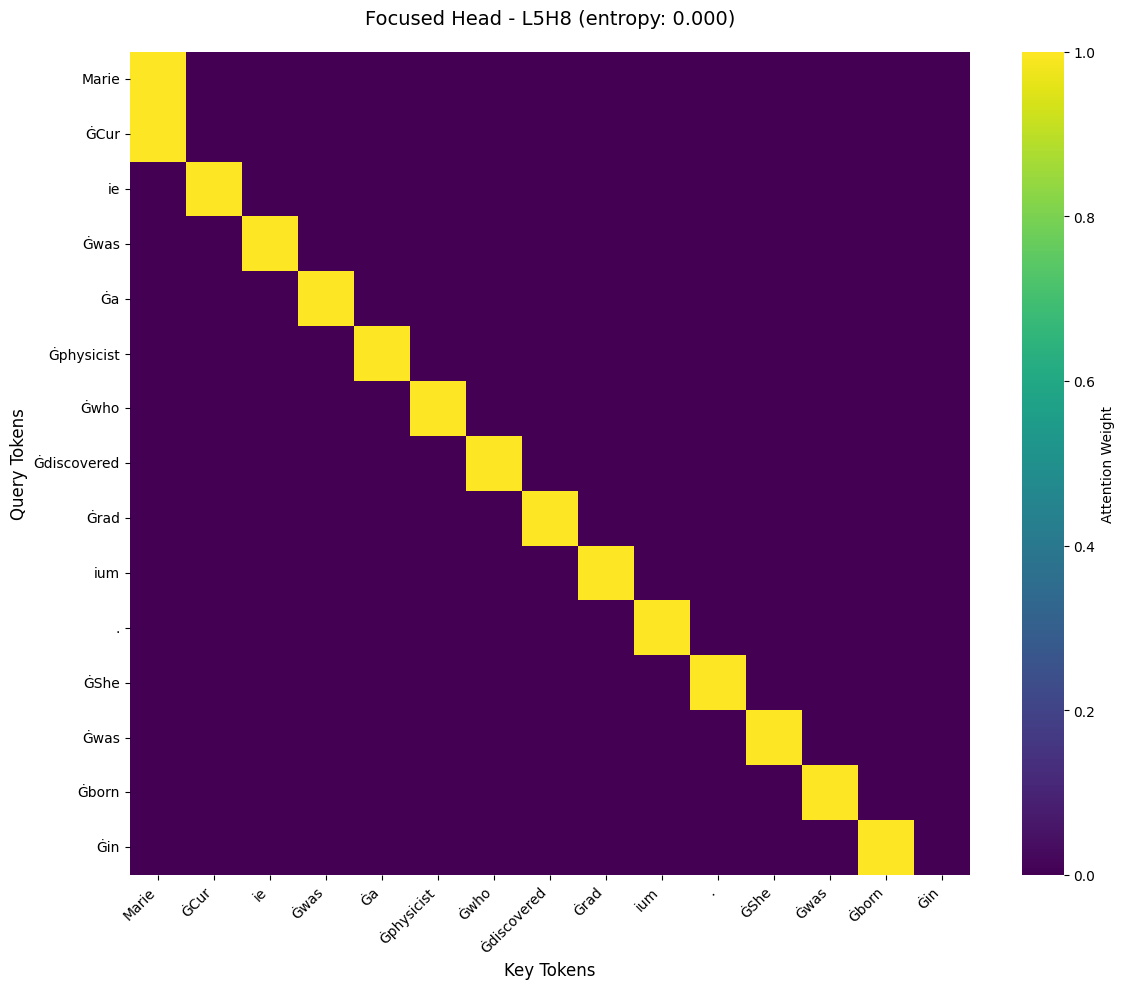

In [36]:
print("Visualizing Previous Token Head:")
top_prev = prev_token_heads.iloc[0]
plot_attention_heatmap(
    first_step_attentions[int(top_prev['layer'])],
    all_tokens[:input_length],
    int(top_prev['layer']),
    int(top_prev['head']),
    f"Previous Token Head - L{int(top_prev['layer'])}H{int(top_prev['head'])} (score: {top_prev['prev_token_score']:.3f})"
)
print("\nVisualizing First Token Head:")
top_first = first_token_heads.iloc[0]
plot_attention_heatmap(
    first_step_attentions[int(top_first['layer'])],
    all_tokens[:input_length],
    int(top_first['layer']),
    int(top_first['head']),
    f"First Token Head - L{int(top_first['layer'])}H{int(top_first['head'])} (score: {top_first['first_token_score']:.3f})"
)
print("\nVisualizing Most Focused Head:")
top_focused = focused_heads.iloc[0]
plot_attention_heatmap(
    first_step_attentions[int(top_focused['layer'])],
    all_tokens[:input_length],
    int(top_focused['layer']),
    int(top_focused['head']),
    f"Focused Head - L{int(top_focused['layer'])}H{int(top_focused['head'])} (entropy: {top_focused['normalized_entropy']:.3f})"
)

- Previous Token Head (L5H8): Perfect diagonal pattern — every token attends exclusively to its immediate predecessor with 100% focus, a pure sequential dependency tracker.

- First Token Head (L8H8): Every query token highlights the first column 
  ("Marie"), using it as a global anchor point. Notably "ĠShe" and "Ġwas"
  show slight secondary attention elsewhere, hinting at coreference resolution 
  beginning to emerge.

- Focused Head (L5H8): Identical to the previous token head — its near-zero 
  entropy confirms it puts 100% of attention on exactly one token (the 
  predecessor), making it the most specialised head in the network.

4. Attention Patterns Across Layers

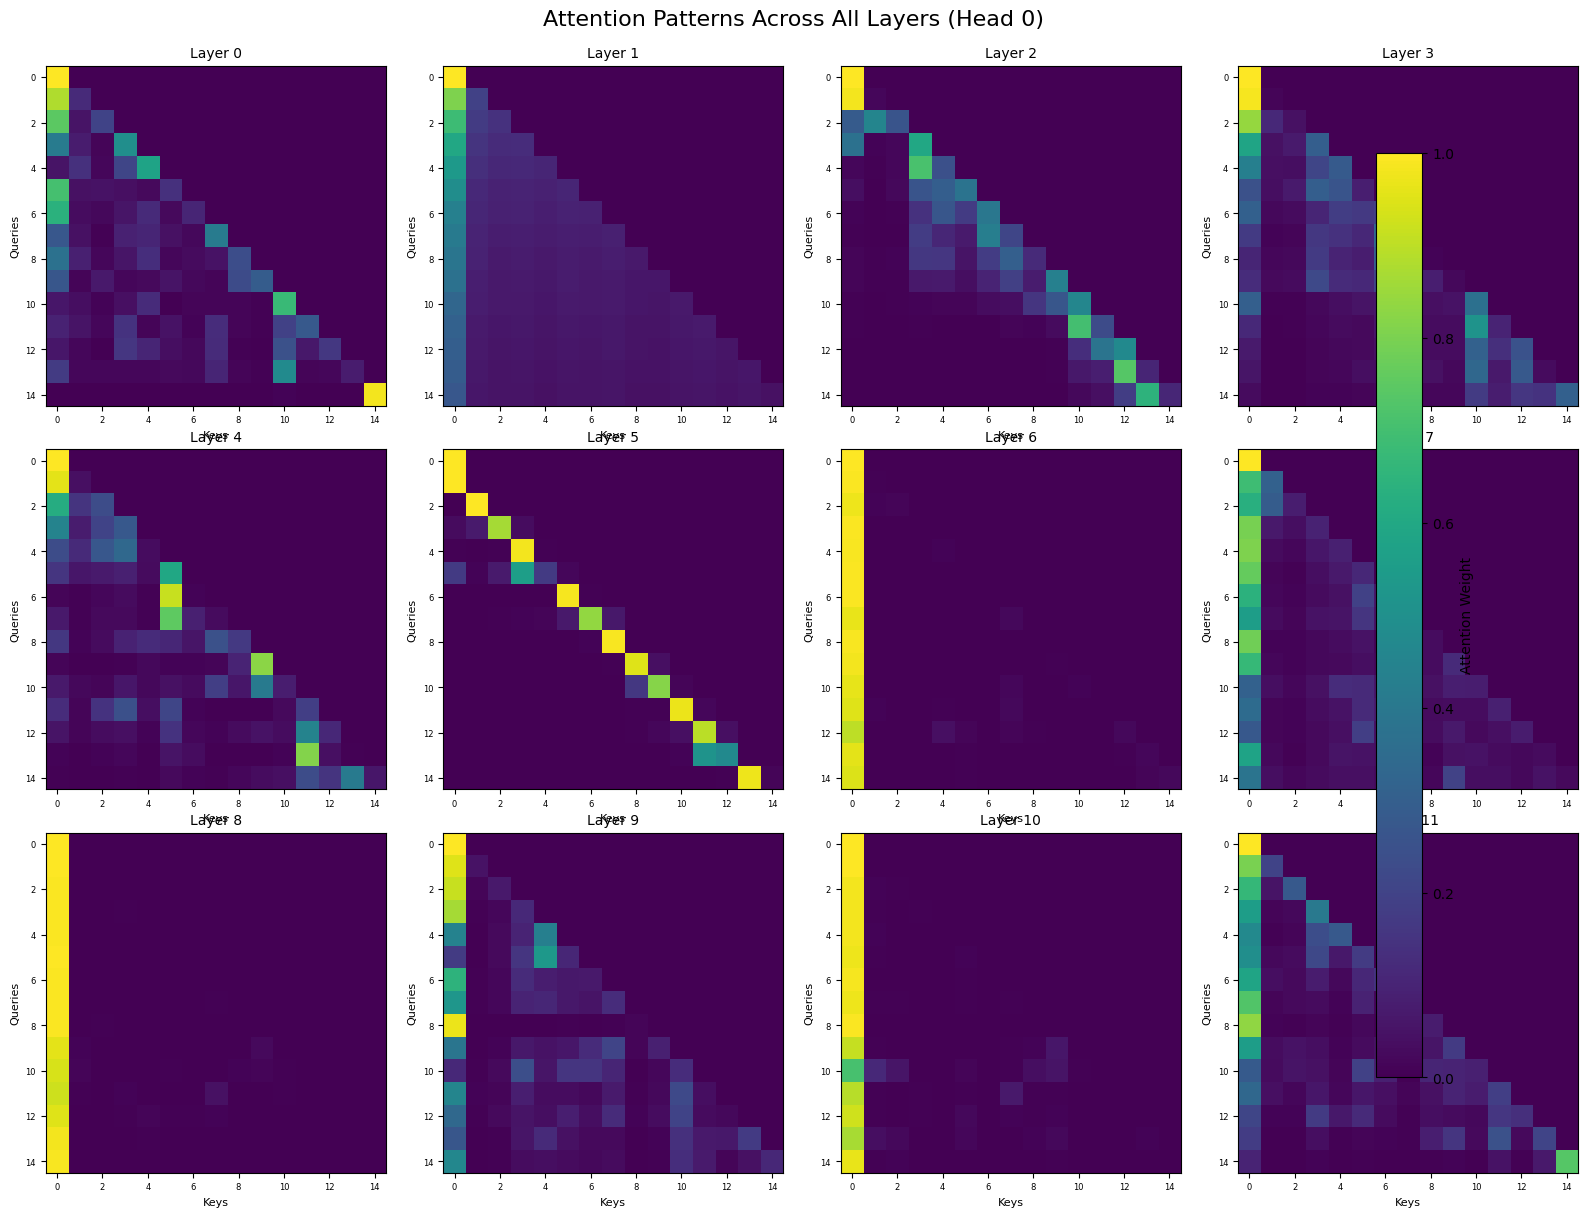

In [37]:
# Visualizing how attention patterns change across layers
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Attention Patterns Across All Layers (Head 0)', fontsize=16, y=1.00)
for layer_idx in range(config.num_layers):
    row = layer_idx // 4
    col = layer_idx % 4
    attn = first_step_attentions[layer_idx][0, 0].cpu().numpy()
    im = axes[row, col].imshow(attn, cmap='viridis', vmin=0, vmax=1)
    axes[row, col].set_title(f'Layer {layer_idx}', fontsize=10)
    axes[row, col].set_xlabel('Keys', fontsize=8)
    axes[row, col].set_ylabel('Queries', fontsize=8)
    axes[row, col].tick_params(labelsize=6)
fig.colorbar(im, ax=axes, label='Attention Weight', fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

- Layers 0-1 show broad, scattered attention across many tokens.
- Layers 2-4 begin developing structure with mixed local and diagonal patterns.
- Layer 5 shows the clearest diagonal pattern — pure previous-token tracking, 
  consistent with L5H8 being the top previous-token head.
- Layers 6 and 8 switch sharply to dominant first-column (`Marie`) attention.
- Layers 9-11 become more distributed again with no clear dominant pattern.

**Progression: broad -> sequential -> first-token anchor -> distributed**

5. Average attention by layer

In [38]:
# Computing average attention statistics per layer
layer_stats = []
for layer_idx in range(config.num_layers):
    layer_attns = first_step_attentions[layer_idx][0]
    # Average across heads
    avg_attn = layer_attns.mean(dim=0).cpu().numpy()
    prev_token_attn = np.mean([avg_attn[i, i-1] for i in range(1, avg_attn.shape[0])])
    first_token_attn = np.mean(avg_attn[:, 0])
    # Computing entropy
    eps = 1e-10
    entropy = -np.sum(avg_attn * np.log(avg_attn + eps), axis=1)
    avg_entropy = np.mean(entropy)
    max_entropy = np.log(avg_attn.shape[1])
    normalized_entropy = avg_entropy / max_entropy
    layer_stats.append({
        'layer': layer_idx,
        'prev_token_attn': prev_token_attn,
        'first_token_attn': first_token_attn,
        'normalized_entropy': normalized_entropy,
    })

df_layers = pd.DataFrame(layer_stats)

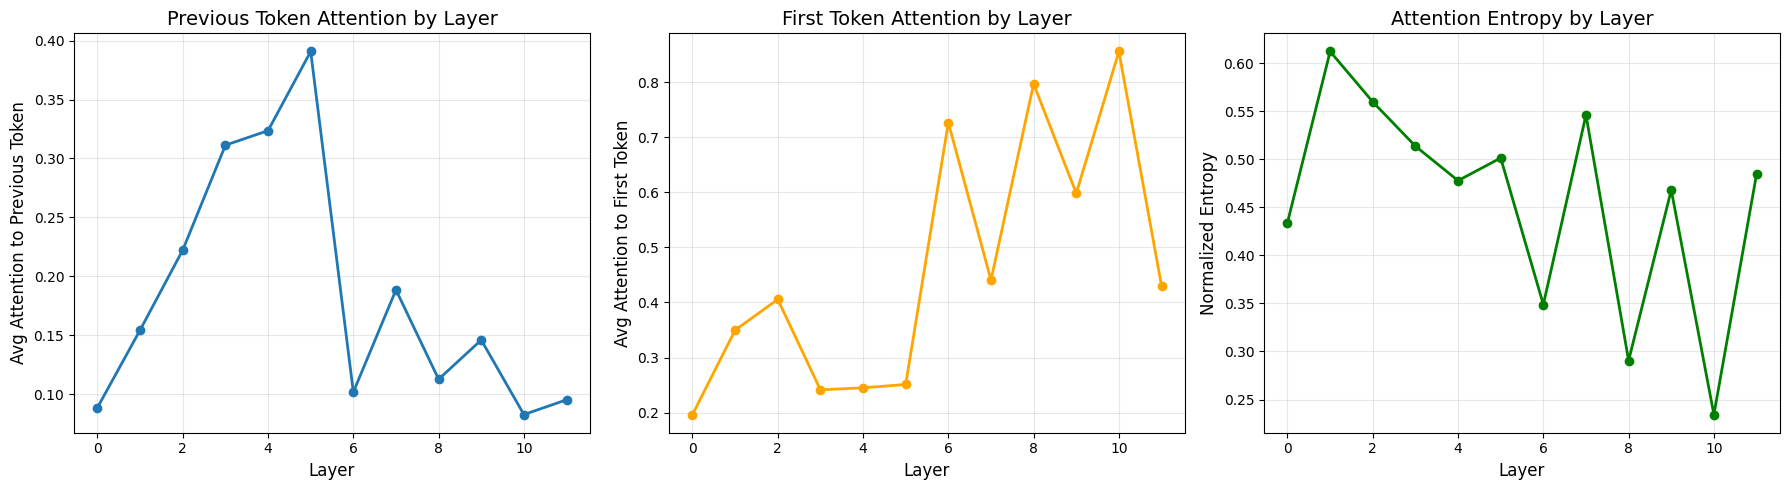

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# Previous token attention
axes[0].plot(df_layers['layer'], df_layers['prev_token_attn'], marker='o', linewidth=2)
axes[0].set_xlabel('Layer', fontsize=12)
axes[0].set_ylabel('Avg Attention to Previous Token', fontsize=12)
axes[0].set_title('Previous Token Attention by Layer', fontsize=14)
axes[0].grid(True, alpha=0.3)
# First token attention
axes[1].plot(df_layers['layer'], df_layers['first_token_attn'], marker='o', linewidth=2, color='orange')
axes[1].set_xlabel('Layer', fontsize=12)
axes[1].set_ylabel('Avg Attention to First Token', fontsize=12)
axes[1].set_title('First Token Attention by Layer', fontsize=14)
axes[1].grid(True, alpha=0.3)
# Entropy
axes[2].plot(df_layers['layer'], df_layers['normalized_entropy'], marker='o', linewidth=2, color='green')
axes[2].set_xlabel('Layer', fontsize=12)
axes[2].set_ylabel('Normalized Entropy', fontsize=12)
axes[2].set_title('Attention Entropy by Layer', fontsize=14)
axes[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Previous token attention peaks at Layer 5 (~0.39), first-token attention 
dominates from Layer 6 onward peaking at Layer 8 (~0.79) and Layer 10 (~0.85), 
and entropy hits its lowest at Layer 9 (~0.24) revealing the network's 
computational strategy: **build local sequential patterns in early-middle layers, 
aggregate globally in later layers, then sharpen for final prediction.**

In [40]:
print("\n1. HEAD SPECIALIZATION:")
print(f"{len(df_heads[df_heads['prev_token_score'] > 0.7])} heads show strong previous token attention (>0.7)")
print(f"{len(df_heads[df_heads['first_token_score'] > 0.5])} heads show strong first token attention (>0.5)")
print(f"{len(df_heads[df_heads['is_focused']])} heads are highly focused (entropy < 0.3)")
print(f"{len(df_heads[df_heads['is_broad']])} heads show broad attention (entropy > 0.7)")
print("\n2. LAYER-WISE PATTERNS:")
early_layers = df_layers[df_layers['layer'] < 4]
late_layers = df_layers[df_layers['layer'] >= 8]
print(f"Early layers (0-3) avg entropy: {early_layers['normalized_entropy'].mean():.3f}")
print(f"Late layers (8-11) avg entropy: {late_layers['normalized_entropy'].mean():.3f}")
print(f"Early layers prev token attn: {early_layers['prev_token_attn'].mean():.3f}")
print(f"Late layers prev token attn: {late_layers['prev_token_attn'].mean():.3f}")
print("\n3. ATTENTION DIVERSITY:")
print(f"Entropy range: {df_heads['normalized_entropy'].min():.3f} to {df_heads['normalized_entropy'].max():.3f}")
print(f"Average entropy across all heads: {df_heads['normalized_entropy'].mean():.3f}")
print(f"Std dev of entropy: {df_heads['normalized_entropy'].std():.3f}")


1. HEAD SPECIALIZATION:
3 heads show strong previous token attention (>0.7)
55 heads show strong first token attention (>0.5)
52 heads are highly focused (entropy < 0.3)
0 heads show broad attention (entropy > 0.7)

2. LAYER-WISE PATTERNS:
Early layers (0-3) avg entropy: 0.530
Late layers (8-11) avg entropy: 0.369
Early layers prev token attn: 0.194
Late layers prev token attn: 0.109

3. ATTENTION DIVERSITY:
Entropy range: 0.000 to 0.649
Average entropy across all heads: 0.337
Std dev of entropy: 0.165


**Conclusion**

GPT-Neo-125M exhibits strong attention specialisation across its 144 heads:
- 55 heads anchor to the first token ("Marie") and 52 are highly focused 
  (entropy < 0.3), while only 3 specialise in previous-token tracking.
- Early layers (0-3) maintain higher entropy (0.530) for broad context 
  gathering, while late layers (8-11) consolidate to lower entropy (0.369) 
  with dominant first-token attention.
- The network's strategy is clear: **broad context early -> sequential 
  pattern detection in Layer 5 -> global aggregation via first-token 
  anchoring from Layer 6 onward.**

**Next: 03 Hidden State Analysis**

Attention tells us *where* the model looks. But what actually happens to the token representations as they pass through each layer? 

Do "Marie" and "Curie" stay geometrically close? Does "She" shift toward the entity it refers to? Notebook 03 tracks the hidden state trajectory of every token across all 13 layers.